In [316]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [315]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.

save_folder = 'SGD-alpha-mu-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

alpha_0 = 10.

In [178]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [179]:
def initialize_centers():

    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_0_k = torch.zeros(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    log_N_k = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_0_k,logvar_c, log_N_k

In [180]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_0_k_g,logvar_c_g,log_N_k_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_0_k_g,logvar_c_g.shape,log_N_k_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0'),
 torch.Size([1, 10, 10]),
 torch.Size([1, 1, 10]))

In [181]:
mu_c_g.requires_grad_(True)
logvar_0_k_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
log_N_k_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [182]:
mu_c_g.requires_grad,logvar_0_k_g.requires_grad,logvar_c_g.requires_grad,log_N_k_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True, True)

In [183]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.9)

optimizer_clustering = optim.Adam([mu_c_g,logvar_0_k_g,logvar_c_g,log_N_k_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.StepLR(optimizer_clustering,step_size=10,gamma=0.9)


In [184]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [185]:
def gauss(mus,logvars,mu_c,logvar_0_k,logvar_c,log_N_k,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2)+logvar_0_k.exp())/(logvar_c.exp())
            log_pi_k = torch.digamma(alpha_0 + log_N_k.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k.exp().sum(2,keepdim = True))

            gamma_c = ((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp())/(((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = ((((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [186]:
#plt.cm.tab20(19)
#colors = plt.get_cmap("tab20")
cm = plt.cm.get_cmap('tab20')
cm.colors[0]
'''
colors = []
for index in range(20):
    colors.append(list(plt.cm.tab20(index)))
'''

def drawpoints(mus_numpy,ts_numpy):
    #colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)
    plt.show()

In [187]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [314]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_0_k_f,logvar_c_f,log_N_k_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    KLD = -0.5*(1+logvars_f).sum() -((((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2)+logvar_0_k_f.exp())/(logvar_c_f.exp())).sum(1,keepdim=True))+torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True))).exp()).sum(2,keepdim=True)).log()).sum() + ((log_N_k_f.exp())*(torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True)))).sum(2).squeeze() + torch.lgamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2).squeeze()) - (torch.lgamma(alpha_0 + log_N_k_f.exp())).sum(2).squeeze()-0.5*logvar_0_k_f.sum()+0.5*(logvar_0_k_f.exp()+mu_c_f.pow(2.)).sum()

    return BCE+beta*KLD

In [189]:
def train_c(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c_g,logvar_0_k_f=logvar_0_k_g,logvar_c_f=logvar_c_g,log_N_k_f=log_N_k_g)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [190]:
def test_c(epoch,mu_c,logvar_0_k,logvar_c,log_N_k):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_0_k_f=logvar_0_k,logvar_c_f=logvar_c,log_N_k_f=log_N_k).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [191]:
def train_c_epoch(epochs,mu_c,logvar_0_k,logvar_c,log_N_k):
    for epoch in range(1, epochs +1):
        train_c(epoch)
        test_c(epoch,mu_c,logvar_0_k,logvar_c,log_N_k)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [192]:
mu_c_g,logvar_0_k_g,logvar_c_g,log_N_k_g

(tensor([[[ 0.1168, -0.9982,  0.0378,  1.4848, -0.1488, -1.0474,  0.1072,
           -0.8728, -0.0412,  0.9624],
          [ 2.3084, -0.1799,  1.5956,  0.4334, -0.7429, -0.4369, -0.8613,
            1.3346, -1.6841, -1.1084],
          [-0.6457,  0.2051, -0.0102, -0.3176, -1.1887,  0.4102,  0.1108,
           -2.0701,  0.3564,  1.1883],
          [-0.8938,  0.9901,  1.9352,  0.7565,  0.9723, -0.4192,  0.4299,
           -0.5126,  0.5502,  0.2463],
          [-1.0900,  2.0025,  0.2403, -0.2589,  0.7183, -0.9522,  1.1246,
           -1.5035,  1.1172,  0.1698],
          [ 0.2301,  2.7887,  0.1090, -0.4202,  0.1525, -0.9537,  0.2884,
           -2.0246, -0.0121, -0.8287],
          [ 1.2627,  1.0362,  0.2467,  1.1496, -0.6114, -0.7121,  0.2931,
            0.8225, -0.0770, -0.3716],
          [-0.5777,  0.2539,  0.1521,  0.7389,  0.3034, -0.2823, -1.5967,
           -0.9741, -0.2967, -2.0214],
          [ 1.0996, -1.7380,  1.3437, -0.5262, -0.3649,  0.5433,  0.2138,
            1.5118, -1

In [300]:
for i in range(100):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i)
    test_c(epoch=i,mu_c=mu_c_g,logvar_0_k=logvar_0_k_g,logvar_c=logvar_c_g,log_N_k=log_N_k_g)
    scheduler.step()
    scheduler_clustering.step()

Train Epoch: 0 [0/60000 (0%)]	Loss: 109.933301
====> Test set loss: 1.1948
Train Epoch: 1 [0/60000 (0%)]	Loss: 106.455527
====> Test set loss: 1.1226
Train Epoch: 2 [0/60000 (0%)]	Loss: 104.311445
====> Test set loss: 1.1025
Train Epoch: 3 [0/60000 (0%)]	Loss: 108.640723
====> Test set loss: 1.1346
Train Epoch: 4 [0/60000 (0%)]	Loss: 108.866641
====> Test set loss: 1.1411
Train Epoch: 5 [0/60000 (0%)]	Loss: 109.576387
====> Test set loss: 1.1403
Train Epoch: 6 [0/60000 (0%)]	Loss: 109.506914
====> Test set loss: 1.1605
Train Epoch: 7 [0/60000 (0%)]	Loss: 111.860313
====> Test set loss: 1.1592
Train Epoch: 8 [0/60000 (0%)]	Loss: 109.883711
====> Test set loss: 1.1903
Train Epoch: 9 [0/60000 (0%)]	Loss: 108.611484
====> Test set loss: 1.2141
Train Epoch: 10 [0/60000 (0%)]	Loss: 108.061592
====> Test set loss: 1.3303
Train Epoch: 11 [0/60000 (0%)]	Loss: 103.876172
====> Test set loss: 1.1872
Train Epoch: 12 [0/60000 (0%)]	Loss: 108.903652
====> Test set loss: 1.1586
Train Epoch: 13 [0/600

In [283]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())

In [284]:
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()

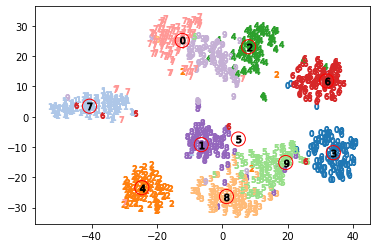

In [285]:
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

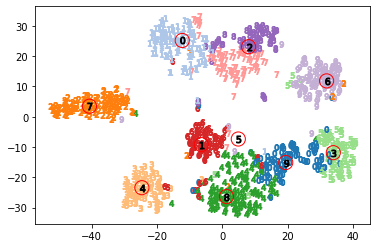

In [286]:
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

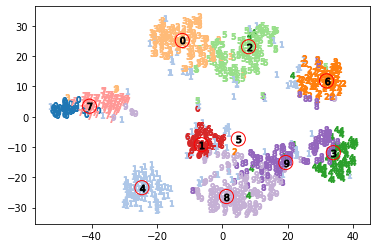

In [301]:
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

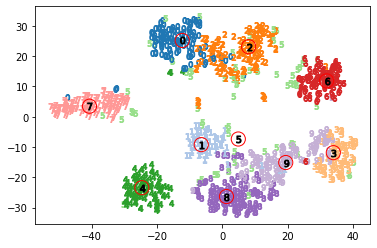

In [302]:
_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_0_k_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [303]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [304]:
#optimizer.param_groups[0]['lr']=0.002
optimizer.param_groups[0]['lr']

0.0001162994740060802

In [305]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1

correspond_matrix

tensor([[  0.,   0.,   0.,  77.,   0.,   6.,   0.,   0.,   0.,  29.],
        [  0.,   1.,   0.,   0.,   0.,   2.,   1., 112.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  92.,   3.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   0.,   0.,   0.,   6.,   0.,   0.,  95.,   2.],
        [  0.,   0.,  85.,   0.,   0.,   9.,   0.,   0.,   0.,   0.],
        [  1.,   2.,   0.,   0.,   0.,   7.,   0.,   0.,  14.,  76.],
        [  0.,   0.,   0.,   0.,   0.,  11.,  89.,   1.,   0.,   1.],
        [ 89.,   0.,   1.,   0.,   3.,  12.,   0.,   0.,   0.,   0.],
        [  0.,  68.,   3.,   0.,   0.,   6.,   0.,   0.,   8.,   1.],
        [ 24.,   0.,  52.,   0.,   0.,   7.,   0.,   0.,   1.,   1.]])

In [306]:
correspond_matrix.sum()

tensor(1000.)

In [307]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([ 89.,  68.,  85.,  77.,  92.,  12.,  89., 112.,  95.,  76.]),
indices=tensor([7, 8, 4, 0, 2, 7, 6, 1, 3, 5]))

In [308]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.7950)

In [309]:
log_N_k_g.exp().squeeze()

tensor([11.3751,  7.6363, 13.1273,  7.1161,  9.1097,  9.0426,  7.9659, 10.0961,
        10.2824,  8.3174], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [310]:

log_N_k_g.exp().squeeze().sum()

tensor(94.0690, device='cuda:0', grad_fn=<SumBackward0>)

In [311]:
mu_c_g

tensor([[[-1.6604e-04, -3.3647e-05, -2.0748e-04, -1.9955e-04,  1.1722e-03,
           2.8444e-04,  5.9414e-04, -5.1594e-04,  9.5792e-04,  2.2027e-04],
         [ 2.8954e+00, -1.6735e-02,  1.6874e+00, -4.1385e+00, -7.4752e-01,
          -1.7059e-01, -1.0316e+00,  2.5563e+00, -1.8854e+00, -1.7440e+00],
         [ 1.5254e+00, -2.0396e+00,  8.5082e-01,  8.7217e-01, -3.6270e-01,
           5.8342e-01, -8.8166e-01, -2.3997e+00, -3.0641e+00, -9.7679e-01],
         [-1.5084e-02, -1.4556e-01, -1.2373e-01,  4.6886e-01,  5.6387e-02,
          -9.1366e-01, -1.2342e-01,  2.5133e-01,  2.1161e-01,  9.3522e-01],
         [-4.0098e-01, -9.6296e-01, -2.1649e+00, -2.0309e+00,  3.6179e+00,
          -9.1409e-01, -1.8899e-01,  1.4573e+00,  3.5480e-01, -2.0679e+00],
         [-1.7355e-04,  1.2069e-03, -2.0002e-04,  2.4269e-04, -6.8185e-04,
           1.5728e-04, -6.5391e-05,  1.2106e-03,  2.0885e-03,  9.6793e-04],
         [ 2.9492e-01,  6.1989e-01, -6.8013e-01, -6.7452e-01,  5.6063e-01,
          -9.8529e-

In [312]:
logvar_0_k_g.exp()

tensor([[[1.6990e-12, 2.4529e-12, 1.5184e-12, 2.3000e-12, 2.1717e-12,
          2.1669e-12, 2.3511e-12, 2.0000e-12, 1.8404e-12, 2.1317e-12],
         [2.6267e-11, 6.9074e-11, 2.1488e-11, 4.3414e-10, 1.3975e-10,
          3.9428e-10, 5.5917e-11, 2.4316e-11, 1.0763e-10, 1.2081e-10],
         [1.2935e-10, 9.6319e-11, 4.7682e-11, 1.2573e-10, 2.4091e-10,
          3.5942e-10, 1.1779e-10, 3.7220e-11, 7.0447e-11, 7.0200e-11],
         [5.2304e-11, 1.7297e-10, 5.2729e-11, 1.5559e-10, 2.5765e-10,
          2.6183e-10, 7.4526e-11, 1.5622e-11, 1.3111e-10, 9.9002e-11],
         [8.8832e-11, 8.2281e-11, 4.4477e-11, 1.1849e-10, 1.0766e-10,
          3.3721e-10, 3.8949e-11, 2.4636e-11, 6.3961e-11, 8.4366e-11],
         [1.6933e-12, 2.4468e-12, 1.5146e-12, 2.2927e-12, 2.1691e-12,
          2.1625e-12, 2.3434e-12, 1.9955e-12, 1.8355e-12, 2.1248e-12],
         [1.8876e-10, 3.3233e-10, 1.9798e-10, 4.7176e-10, 2.2127e-10,
          5.7451e-10, 1.8171e-10, 3.1541e-10, 2.3996e-10, 2.9805e-10],
         [6.6

In [313]:
logvar_c_g.exp()

tensor([[[0.0183, 0.0182, 0.0183, 0.0184, 0.0185, 0.0183, 0.0181, 0.0188,
          0.0185, 0.0183],
         [0.4160, 0.7800, 0.3961, 2.1107, 1.8811, 5.1720, 0.6236, 0.3292,
          1.7751, 1.0261],
         [2.1155, 1.0651, 0.8626, 1.4210, 3.2525, 4.2714, 1.4608, 0.5072,
          1.0477, 0.9311],
         [0.7412, 1.8196, 0.8501, 1.7233, 3.2855, 2.8924, 0.7561, 0.1730,
          1.9981, 1.2085],
         [1.4394, 0.8792, 0.7594, 1.2448, 1.3579, 3.5794, 0.4308, 0.3223,
          0.9175, 1.1828],
         [0.0184, 0.0185, 0.0185, 0.0185, 0.0186, 0.0185, 0.0184, 0.0190,
          0.0186, 0.0186],
         [3.0303, 3.8050, 3.6471, 4.3654, 2.9308, 8.2640, 2.0353, 4.4851,
          3.7382, 4.3606],
         [1.0137, 1.2966, 1.0896, 1.9884, 2.2383, 4.3058, 1.6533, 0.0537,
          1.7830, 1.1607],
         [0.0183, 0.0184, 0.0184, 0.0183, 0.0186, 0.0184, 0.0182, 0.0189,
          0.0186, 0.0184],
         [0.6053, 0.8343, 2.8980, 1.4707, 2.9937, 5.0048, 1.0116, 0.2946,
          2.1371,